In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
signal = np.load('signal_50.npy')
radi = np.load('radii_50.npy')
f_sphere = np.load('f_sphere_50.npy')
f_ball = np.load('f_ball_50.npy')
f_stick = np.load('f_stick_50.npy')


In [2]:
s = signal[64:].reshape(32,32,120)
r = radi[64:].reshape(32,32)
f_s = f_sphere[64:].reshape(32,32)
f_b = f_ball[64:].reshape(32,32)
f_stick = f_stick[64:].reshape(32,32)



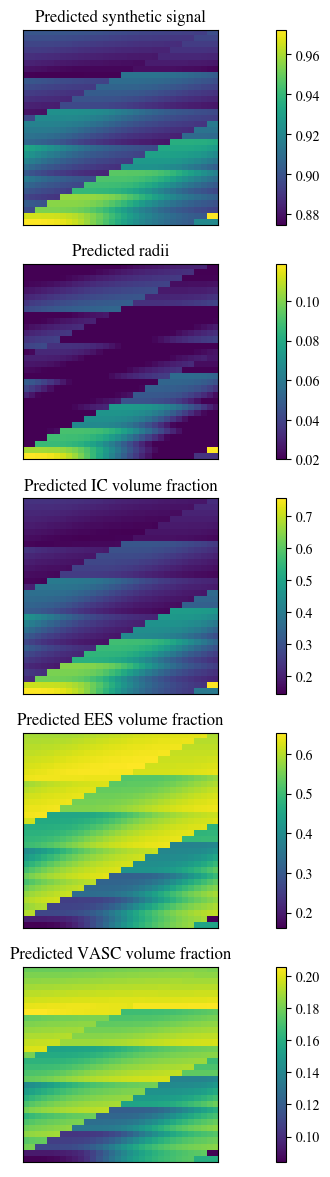

In [4]:
fig, ax = plt.subplots(5,figsize = (15,15))

im1 = ax[0].imshow(s[:,:,0])

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('Predicted synthetic signal')
cb0 = fig.colorbar(im1,ax=ax[0])


im2 = ax[1].imshow(r)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('Predicted radii')
cb1 = fig.colorbar(im2,ax=ax[1])


im3 = ax[2].imshow(f_s)

ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[2].set_title('Predicted IC volume fraction')
cb2 = fig.colorbar(im3,ax=ax[2])


im4 = ax[3].imshow(f_b)

ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[3].set_title('Predicted EES volume fraction')
cb2 = fig.colorbar(im4,ax=ax[3])


im5 = ax[4].imshow(f_stick)

ax[4].get_xaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[4].set_title('Predicted VASC volume fraction')
cb2 = fig.colorbar(im5,ax=ax[4])

plt.rcParams["font.family"] = "times"
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10



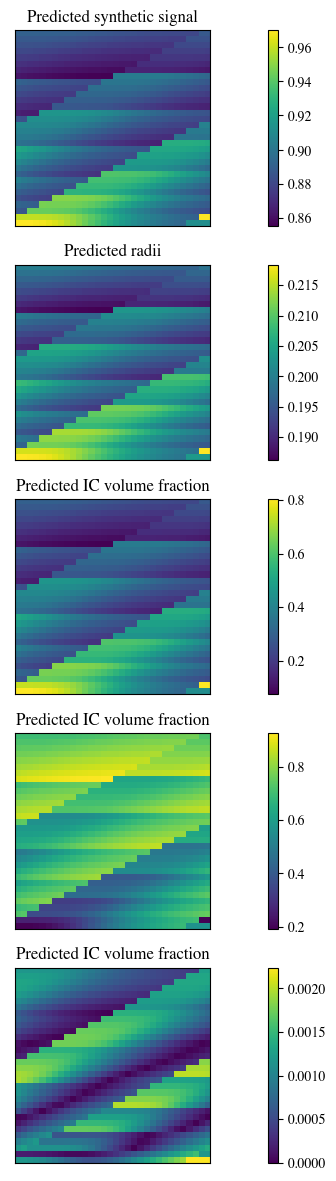

In [18]:
fig, ax = plt.subplots(5,figsize = (15,15))

im1 = ax[0].imshow(s[:,:,0])

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('Predicted synthetic signal')
cb0 = fig.colorbar(im1,ax=ax[0])


im2 = ax[1].imshow(r)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('Predicted radii')
cb1 = fig.colorbar(im2,ax=ax[1])


im3 = ax[2].imshow(f_s)

ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[2].set_title('Predicted IC volume fraction')
cb2 = fig.colorbar(im3,ax=ax[2])


im4 = ax[3].imshow(f_b)

ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[3].set_title('Predicted IC volume fraction')
cb2 = fig.colorbar(im4,ax=ax[3])


im5 = ax[4].imshow(f_stick)

ax[4].get_xaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[4].set_title('Predicted IC volume fraction')
cb2 = fig.colorbar(im5,ax=ax[4])

plt.rcParams["font.family"] = "times"
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10



## NIB to numpy

In [6]:
import nibabel as nib

data = nib.load("/Users/theavage/Documents/Master/Data/GS55 - long acquisition/GS55_all.nii.gz").get_fdata()


In [34]:
img = data[:,:,8,:].reshape(65536,160)

new = np.zeros([65536,120])
j = 0

for i in range(len(img[1])):
    if i!=0 and (i%4)!=0:
        new[:,j]= img[:,i]
        j+=1


np.save('simulated_65536x10.npy',new)

In [33]:
new.shape

(65536, 120)